In [1]:
from numqt import *
import numpy as np
import matplotlib.pyplot as plt


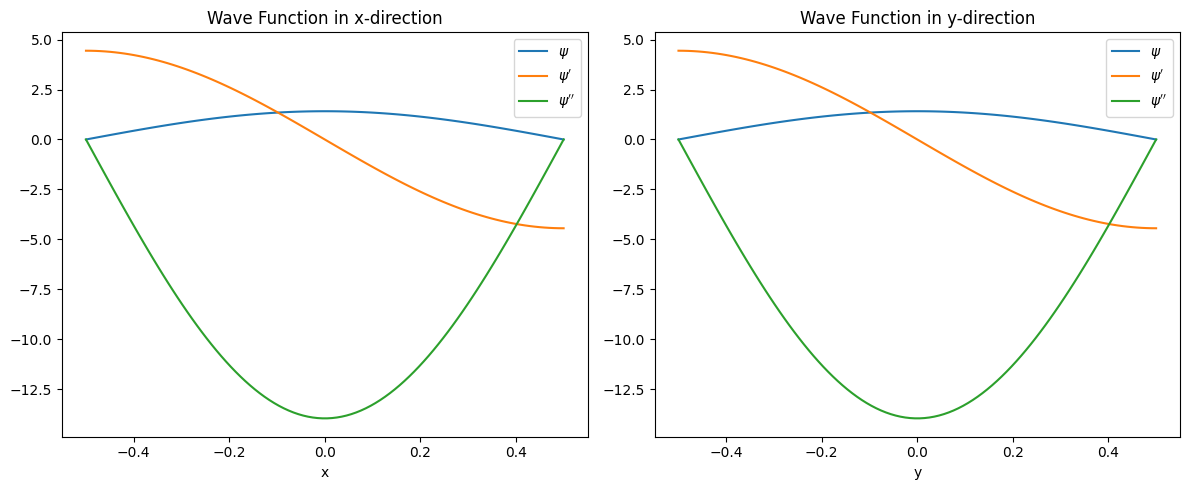

In [2]:
# ===========================================================
# Setup 
# ===========================================================
Lx = 1 # Characteristic length along x
Ly = 1 # Characteristic length along y
hbar = 1
m = 1
q = -1
# ===========================================================
# Simulation parameters
# ===========================================================
xbounds = (-Lx/2, Lx/2) # confinement length
ybounds = (-Ly/2, Ly/2) # confinement length
dx = 0.01 # spacing
dy = 0.01 # spacing
nx = int(np.abs(xbounds[1] - xbounds[0]) / dx)
ny = int(np.abs(ybounds[1] - ybounds[0]) / dx)

# ===========================================================
# Mesh and basis setup
# ===========================================================
mesh = Mesh(dims=2,
                xbounds=xbounds,
                ybounds=ybounds,
                nx=nx, 
                ny=ny)

dimx = mesh.Nx
dimy = mesh.Ny

N_states = 5

psix_fn = lambda n, mesh: iw_state(n, mesh, center=0, L=Lx)  
psiy_fn = lambda n, mesh: iw_state(n, mesh, center=0, L=Ly) 
basis = {"x": (psix_fn, N_states),
         "y": (psiy_fn, N_states),}

# ===========================================================
# Plotting
# ===========================================================
state = 0
labels = [r"$\psi$", r"$\psi'$", r"$\psi''$"]
psi_x = psix_fn(state, mesh.mesh_x)
psi_y = psiy_fn(state, mesh.mesh_y)

# Create a figure with two subplots side by side.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for i in range(3):
    ax1.plot(mesh.mesh_x, psi_x[i], label=labels[i])
    ax2.plot(mesh.mesh_y, psi_y[i], label=labels[i])
    
ax1.set_xlabel("x")
ax2.set_xlabel("y")
ax1.set_title("Wave Function in x-direction")
ax2.set_title("Wave Function in y-direction")
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

In [3]:
# ===========================================================
# Obtaining canonical operators
# ===========================================================
operators = canonic_ops(mesh, basis = basis, ops_to_compute = ["p2", "x"], additional_subspaces = None, hbar=1, limit_divisions=max(nx, ny))
px2 = operators.get_ops()["p2"][0]
py2 = operators.get_ops()["p2"][1]
x = operators.get_ops()["x"][0]
y = operators.get_ops()["x"][1]


# ===========================================================
# Constructing the Hamiltonian
# ===========================================================
H0 = (px2 + py2) / (2*m)

In [4]:
# ===========================================================
# EXAMPLE 1: Single array parameter (E0_vals): SINGLE DRIVE
# ===========================================================
print("=== EXAMPLE 1: Array of E0 values ===")

omega = 0.95 * 3 * hbar * np.pi**2 / (2 * m * Lx**2)
T = 2 * np.pi / omega
E0_vals = np.linspace(0, - 10 * hbar * omega / (q * Lx), 300)

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega,
    "periods": T
}

# Time-dependent Hamiltonian
H_dip = lambda E0, w, t: - q * E0 * np.cos(w * t) * x

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_dip, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

# This should return shape (len(E0_vals), N_states)
quasi_energies_1D = H_array_E0.solve_quasi_energies(Nt=300, rescale_omega=omega, brillouin_omega=omega)

=== EXAMPLE 1: Array of E0 values ===
Computing quasi-energies: 300 amplitudes × 1 frequency
Output shape: (300, 25)
Progress: 30/300 (10.0%)
Progress: 60/300 (20.0%)
Progress: 90/300 (30.0%)
Progress: 120/300 (40.0%)
Progress: 150/300 (50.0%)
Progress: 180/300 (60.0%)
Progress: 210/300 (70.0%)
Progress: 240/300 (80.0%)
Progress: 270/300 (90.0%)
Progress: 300/300 (100.0%)
Computed quasi-energies with shape: (300, 25)


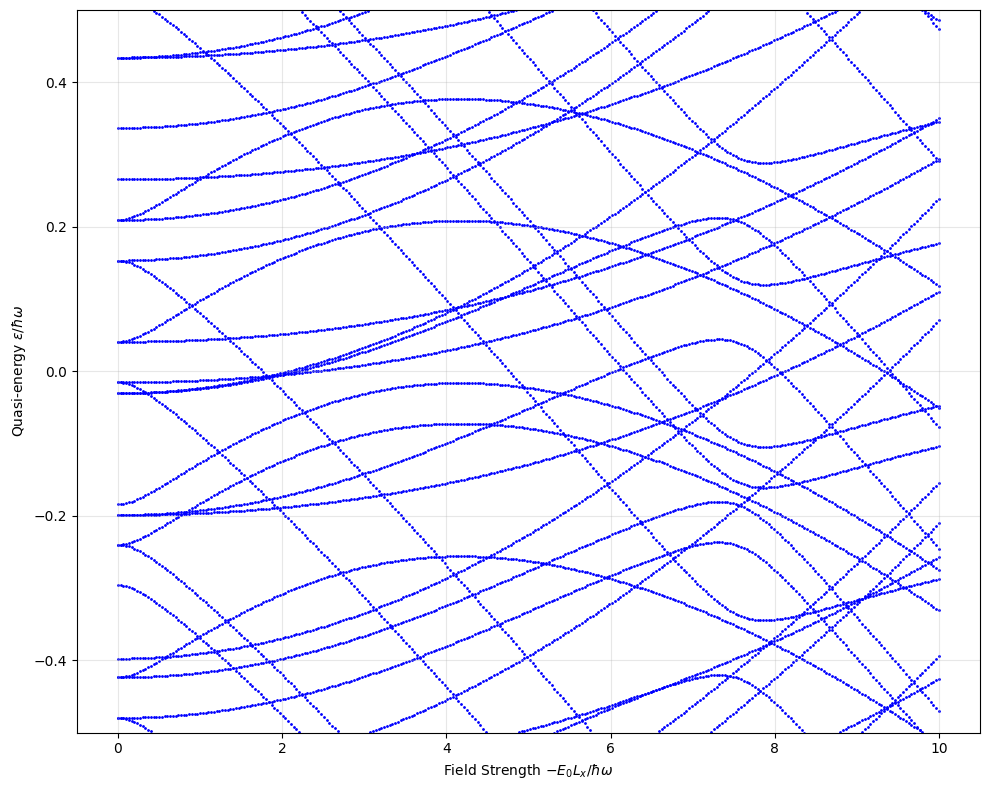

In [5]:
E0_normalized = - E0_vals * q * Lx / (hbar * omega)

fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(25,N_states*N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_1D[:, n], c = "b", s=1,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L_x / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()